## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K
from keras import losses

def combined_loss(ce_w, gamma=2., alpha=4.):
    ce_w = float(ce_w)
    gamma = float(gamma)
    alpha = float(alpha)
    def ce_loss_core(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        # combine
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return ce_loss*ce_w + tf.reduce_mean(reduced_fl)*(1-ce_w)
        
    return ce_loss_core

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print('Numbers of exp: %i, ce_weight: %.2f' % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
  
    model.compile(loss=combined_loss(ce_w), metrics=['accuracy'], optimizer=optimizer)


    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ('exp-%s' % (i))
    results[exp_name_tag] = {'train-loss': model.history.history['loss'],
                             'valid-loss': model.history.history['val_loss'],
                             'train-acc': model.history.history['acc'],
                             'valid-acc': model.history.history['val_acc']}

Numbers of exp: 0, ce_weight: 0.00




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 289us/step - loss: 4.8694 - acc: 0.3234 - val_loss: 4.9102 - val_acc: 0.3487
Epoch 2/25
50000/50000 [==============================] - 9s 181us/step - loss: 3.6058 - acc: 0.4391 - val_loss: 3.9055 - val_acc: 0.4091
Epoch 3/25
50000/50000 [==============================] - 9s 178us/step - loss: 3.2755 - acc: 0.4781 - val_loss: 3.5829 - val_acc: 0.4381
Epoch 4/25
50000/50000 [==============================] - 9s 178us/step - loss: 3.0594 - acc: 0.5054 - val_loss: 3.4779 - val_acc: 0.4414
Epoch 5/25
50000/50000 [==============================] - 9s 180us/step - loss: 2.9000 - acc: 0.5269 - val_loss: 3.3396 - val_acc: 0.4598
Epoch 6/25
50000/50000 [==============================] - 9s 179us/step - loss: 2.7542 - acc: 0.5438 - val_loss: 3.2964 - val_acc: 0.4660
Epoch 7/25
50000/50000 [==============================] - 10s 206us/step - loss: 2.6339 - acc: 0.5624 - val_loss: 3.3027 

Epoch 24/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.1279 - acc: 0.7635 - val_loss: 2.9199 - val_acc: 0.4874
Epoch 25/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.0748 - acc: 0.7741 - val_loss: 2.9703 - val_acc: 0.4924
Numbers of exp: 3, ce_weight: 0.70
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Bat

50000/50000 [==============================] - 9s 180us/step - loss: 1.2722 - acc: 0.5585 - val_loss: 1.4803 - val_acc: 0.4772
Epoch 12/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.2478 - acc: 0.5654 - val_loss: 1.4733 - val_acc: 0.4767
Epoch 13/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.2210 - acc: 0.5769 - val_loss: 1.4636 - val_acc: 0.4811
Epoch 14/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.1947 - acc: 0.5867 - val_loss: 1.4639 - val_acc: 0.4847
Epoch 15/25
50000/50000 [==============================] - 9s 180us/step - loss: 1.1709 - acc: 0.5960 - val_loss: 1.4709 - val_acc: 0.4851
Epoch 16/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.1487 - acc: 0.6030 - val_loss: 1.4610 - val_acc: 0.4917
Epoch 17/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.1247 - acc: 0.6133 - val_loss: 1.4498 - val_acc: 0.4914
Epoch 18/25
50000/50000 [==============

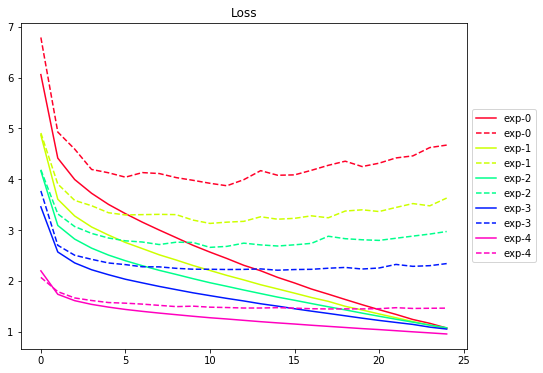

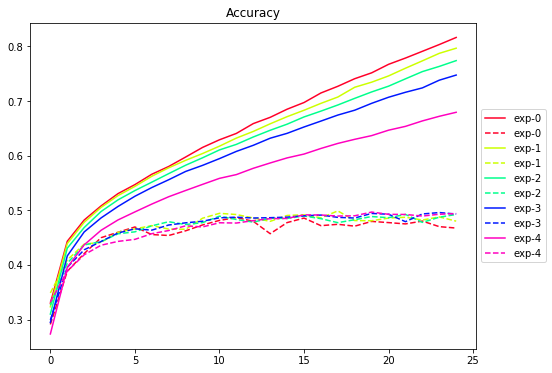

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()